[Hands on RL Policy Gradient](https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%204/4.3%20Policy%20Gradients%20REINFORCE.ipynb)

[Policy Gradient Math](https://towardsdatascience.com/policy-gradients-in-reinforcement-learning-explained-ecec7df94245)

A widely used variation of REINFORCE is to subtract a baseline value from the return to reduce the variance of gradient estimation while keeping the bias unchanged (Remember we always want to do this when possible). For example, a common baseline is to subtract state-value from action-value, and if applied, we would use advantage:

$$
A(s,a) = Q(s,a) - V(s)
$$

in the gradient ascent update. This [post](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/) nicely explained why a baseline works for reducing the variance, in addition to a set of fundamentals of policy gradient.

In [11]:
#!pip install swig
#!pip install gymnasium[box2d]

## Policy Gradient with Baseline

![Reinforce_bl](reinforce_bl.png) 

In [1]:
import torch
from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.distributions import Categorical
import math

import gymnasium as gym
import os, random
from pathlib import Path
from collections import deque

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from IPython.display import clear_output

In [2]:
env_id = "LunarLander-v2"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  8
Sample observation [ 1.2014778  -1.2103204  -0.9940599   1.7621666  -1.5575687   2.9986942
  0.7717283   0.72506833]


In [3]:
device = device("cuda:0" if cuda.is_available() else "cpu")

In [4]:
def calc_disc_return(r_t , gamma = 0.998):

    G_t = deque(maxlen = len(r_t))
    G_t.append(r_t[-1])

    for i in reversed(r_t[:-1]):
        disc = i + (gamma*G_t[0])
        G_t.appendleft(disc)

    return np.array(G_t)

class PolicyNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(PolicyNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim = 1)

class ValueNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

class Agent():
    def __init__(self, state_size, action_size, hidden_size, gamma = 0.99, learning_rate = 0.001):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        
        self.policy_net = PolicyNet(state_size, action_size, hidden_size).to(device)
        self.value_net = ValueNet(s_size, hidden_layer).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = learning_rate)
        self.v_optimizer = optim.Adam(self.value_net.parameters(), lr = learning_rate)
    
    def train(self, states, rewards, actions):
        
        state_t = torch.FloatTensor(states).to(device)
        action_t = torch.LongTensor(actions).to(device).view(-1,1)
        return_t = torch.FloatTensor(calc_disc_return(rewards, gamma)).to(device).view(-1,1)
        
        eps = np.finfo(np.float32).eps.item()
        return_t = (return_t - return_t.mean()) / (return_t.std() + eps)
    
        vf_t = self.value_net(state_t).to(device)
        with torch.no_grad():
            adv_t = return_t - vf_t
    
        action_prob = self.policy_net(state_t).gather(1, action_t)
        loss = torch.sum(-torch.log(action_prob) * adv_t)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        loss_fn = nn.MSELoss()
        vf_loss = loss_fn(vf_t, return_t)
        self.v_optimizer.zero_grad()
        vf_loss.backward()
        self.v_optimizer.step()

        grads = np.concatenate([p.grad.data.detach().cpu().numpy().flatten()
                                for p in self.policy_net.parameters()
                                if p.grad is not None])
        
        grad_l2 = np.sqrt(np.mean(np.square(grads)))
        grad_max = np.max(np.abs(grads))
    
        return loss.item(), grad_l2, grad_max
    
    def save(self, model_file):
        torch.save({
            'policy_net_dict': self.policy_net.state_dict(),
            'value_net_dict': self.value_net.state_dict(),
            }, model_file)
        
    def load(self, model_file):
        checkpoint = torch.load(model_file)
        self.policy_net.load_state_dict(checkpoint['policy_net_dict'])
        self.value_net.load_state_dict(checkpoint['value_net_dict'])

In [5]:
hidden_layer = 64
gamma = 0.995
policy_lr = 0.001
value_lr = 0.001
episodes = 100_000
avg_win_size = 50
epi_results = deque(maxlen=avg_win_size)

agent = Agent(s_size, a_size, hidden_layer,  gamma = gamma)

In [6]:
log_file_name = os.path.join('.','artefacts',f'{env_id}_policygradient_bl.csv')
model_file = os.path.join('.','models',f'{env_id}_policygradient_bl.pt')

In [8]:
train = True
if train:
    log_file = open(log_file_name, "w")
    log_file.write(f'episode,rewards,loss,l2_grad,max_grad\n')

for epi in range(episodes):

    if not train:
        print("set train flag to True for Training")
        break
        
    s = env.reset()[0]
    term , trunc = False, False
    rewards, states , actions = [], [], []
    win = 0

    while not any([term, trunc]):

        states.append(s)
        obs = torch.FloatTensor(np.expand_dims(s,0)).to(device)

        with torch.no_grad():
            p_vals = agent.policy_net(obs)
            p_vals = torch.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        a = np.random.choice(a_size, p=p_vals)

        s_, r, term ,trunc, _  = env.step(a)
        actions.append(a)
        rewards.append(r)
        s=np.copy(s_)

    epi_results.append(np.sum(rewards))
    loss, grad_l2, grad_max = agent.train(states, rewards, actions)
    log_file.write(f'{epi},{np.sum(rewards):.2f},{loss:.2f},{grad_l2:.4f},{grad_max:.4f}\n')
    
    if epi%100==0:
        clear_output()
    if epi%10==0:
        print(f'epi:{epi:05d} reward:{np.sum(rewards):8.2f} loss:{loss:8.2f} mean_rewards:{np.mean(epi_results):8.2f}')
    if np.mean(np.mean(epi_results))>200:
        break

if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

epi:01300 reward:  204.32 loss:  -51.80 mean_rewards:  187.51
epi:01310 reward:  248.24 loss:  109.89 mean_rewards:  189.16
epi:01320 reward:  231.21 loss:   13.14 mean_rewards:  199.07
Saving Agent as .\models\LunarLander-v2_policygradient_bl.pt


In [9]:
eval_agent = Agent(s_size, a_size, hidden_layer)
eval_agent.load(model_file) 
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Gradient')

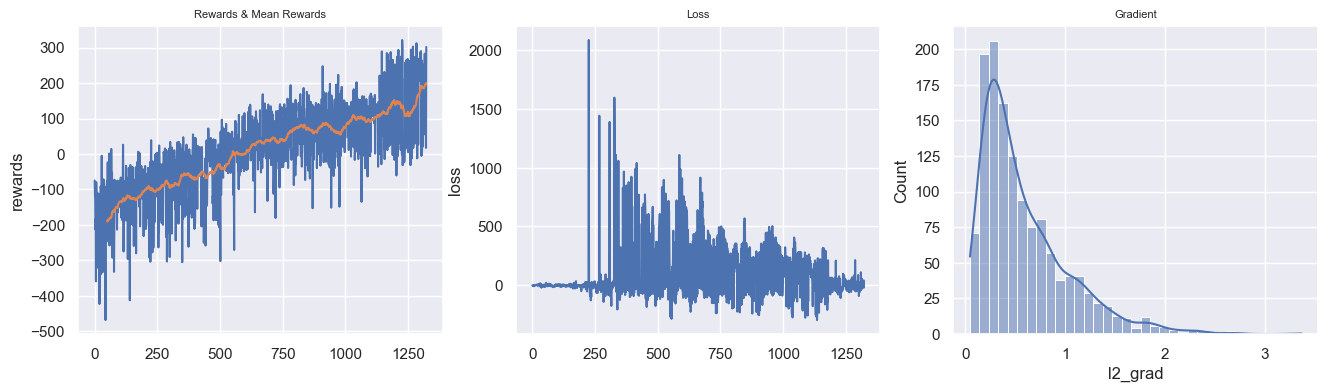

In [10]:
fig,ax=plt.subplots(1,3,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['loss'],ax = ax[1])
ax[1].set_title('Loss',fontsize=8)
sns.histplot(df['l2_grad'],ax = ax[2], kde = True)
ax[2].set_title('Gradient',fontsize=8)

In [12]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    score = 0
    n=0
    while not any([term, trunc]):
    #while not done:
        obs = torch.FloatTensor(np.expand_dims(s,0)).to(device)

        with torch.no_grad():
            p_vals = eval_agent.policy_net(obs)
            p_vals = torch.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        #a = np.random.choice(a_size, p=p_vals)
        a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
        #s, r, done ,_ , _  = eval_env.step(a)
        #s = np.copy(s_)
        #env.render()
        n+=1
        score+=r
        if score >=200:
            break

    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result 213.68
epi = 1 result 252.17
epi = 2 result 254.43
epi = 3 result 206.98
epi = 4 result 261.04
epi = 5 result 203.67
epi = 6 result 234.18
epi = 7 result 270.89
epi = 8 result 226.86
epi = 9 result -49.51
